# Project Detection Using Kalman Filter for Motion

You are allowed to use `torch.nn`.

In [ ]:
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image, to_tensor
import torchvision.transforms.functional as F

from sklearn.manifold import TSNE

--2025-01-29 18:56:12--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.234.89, 3.5.20.106, 52.217.202.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.234.89|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip.1’

val2017.zip.1         4%[                    ]  32.42M  9.28MB/s    eta 92s    ^C
Archive:  val2017.zip
replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
114 114
torch.Size([4, 505, 240]) torch.Size([3, 505, 240])


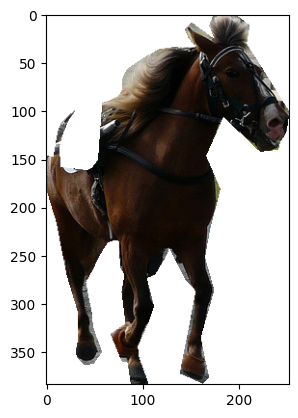

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

subset_name = 'val2017'

img_size = 224
transformations = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

coco = CocoDetection( f'val2017', annFile=f'horse_annotations.json', transforms=transformations)
len(coco)

def get_crop(x, use_mask=None):
    out = []
    img = x[0]
    for bb in x[1]:
        mask = coco.coco.annToMask(bb)
        bb = torch.tensor(bb['bbox']).long()
        img_new = img.clone()

        if use_mask == 'multiply':
            img_new = img_new * mask
        elif use_mask == 'concat':
            img_new = torch.cat([img_new, torch.from_numpy(mask)[None]])

        img_new = img_new[:, bb[1]:bb[1] + bb[3], bb[0]:bb[0] + bb[2]]
        if img_new.shape[1] > 50 and img_new.shape[2] > 50:
            out += [img_new]
    return out

all_crops_concat = [y for x in coco for y in get_crop(x, use_mask='concat')]
all_crops_multiply = [y for x in coco for y in get_crop(x, use_mask='multiply')]
print(len(all_crops_concat), len(all_crops_multiply))
print(all_crops_concat[0].shape, all_crops_multiply[0].shape)
plt.imshow(all_crops_concat[5].permute(1,2,0))

### 1. ReID Training

Train instance discrimination on the following dataset of horse images: `all_crops`.
Visualize the resulting embeddings using t-SNE (see example below). Do similar images appear close to each other?  

Can this clustering performance be improved by:
* masking the background (`use_mask=True`)?
* using augmentations?

114


(0.0, 1.0)

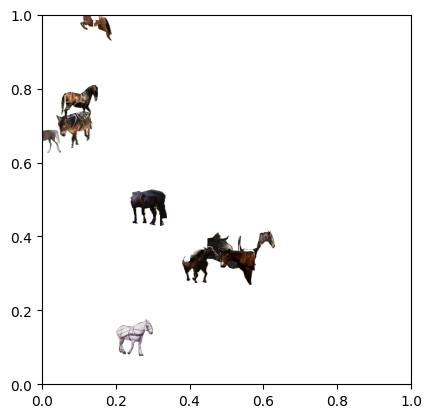

In [ ]:
all_crops_alpha = [y for x in coco for y in get_crop(x, use_mask='concat')]

print(len(all_crops_alpha))

fig, ax = plt.subplots()

x = np.random.rand(10)
y = np.random.rand(10)

for xi, yi, img in zip(x, y, all_crops_alpha[:10]):
    ax.imshow(img.permute(1,2,0), extent=(xi-0.05, xi+0.05, yi-0.05, yi+0.05))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


In [ ]:
# Calculate mean and std for all_crops_concat (4 channels)
temp_concat = torch.cat([crop.contiguous().view(4, -1) for crop in all_crops_concat], dim=1)
mean_concat = temp_concat.mean(dim=1).tolist()
std_concat = temp_concat.std(dim=1).tolist()

print(f"Calculated Mean (Concat): {mean_concat}")
print(f"Calculated Std (Concat): {std_concat}")

# Calculate mean and std for all_crops_multiply (3 channels)
temp_multiply = torch.cat([crop.contiguous().view(3, -1) for crop in all_crops_multiply], dim=1)
mean_multiply = temp_multiply.mean(dim=1).tolist()
std_multiply = temp_multiply.std(dim=1).tolist()

print(f"Calculated Mean (Multiply): {mean_multiply}")
print(f"Calculated Std (Multiply): {std_multiply}")


Calculated Mean (Concat): [0.4207237660884857, 0.3823027014732361, 0.3179587423801422, 0.44693756103515625]
Calculated Std (Concat): [0.26587313413619995, 0.2622227072715759, 0.25677311420440674, 0.4971764385700226]
Calculated Mean (Multiply): [0.16049188375473022, 0.1298854649066925, 0.10838084667921066]
Calculated Std (Multiply): [0.24599692225456238, 0.21157333254814148, 0.19013072550296783]


In [ ]:
#Creating out model:
embedding_dim = 128

backbone = models.resnet50(pretrained=True)
backbone.fc = nn.Linear(backbone.fc.in_features, embedding_dim)

class InstanceDiscriminationModel(nn.Module):
    def __init__(self, backbone):
        super(InstanceDiscriminationModel, self).__init__()
        self.backbone = backbone

    def forward(self, x):
        embedding = self.backbone(x)
        embedding = nn.functional.normalize(embedding, p=2, dim=1)
        return embedding

model_multiply = InstanceDiscriminationModel(backbone)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
embedding_dim = 128

# Load ResNet50 backbone
backbone_concat = models.resnet50(pretrained=True)
#Backbone for 4 channels
backbone_concat.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Initialize the new channel (e.g., with the same weights as the first channel)
with torch.no_grad():
    backbone_concat.conv1.weight[:, :3, :, :] = backbone.conv1.weight  # Copy existing weights
    backbone_concat.conv1.weight[:, 3:, :, :] = backbone.conv1.weight[:, :1, :, :]  # Initialize the 4th channel

# Replace the fully connected layer
backbone_concat.fc = nn.Linear(backbone_concat.fc.in_features, embedding_dim)

class InstanceDiscriminationModelConcat(nn.Module):
    def __init__(self, backbone):
        super(InstanceDiscriminationModelConcat, self).__init__()
        self.backbone = backbone

    def forward(self, x):
        embedding = self.backbone(x)
        embedding = nn.functional.normalize(embedding, p=2, dim=1)
        return embedding

model_concat = InstanceDiscriminationModelConcat(backbone_concat)


In [ ]:
class AugmentedCocoDataset(torch.utils.data.Dataset):
    def __init__(self, all_crops, augmentations, num_augmentations=2, include_original=False, img_size=224, mean=None, std=None):
        self.all_crops = all_crops
        self.augmentations = augmentations
        self.num_augmentations = num_augmentations
        self.include_original = include_original
        self.img_size = img_size
        if include_original:
            assert mean is not None and std is not None, "Mean and std must be provided if include_original is True."
            self.mean = mean
            self.std = std


    def __len__(self):
        return len(self.all_crops)

    def __getitem__(self, idx):
        original_crop = self.all_crops[idx]  # This is a Tensor

        # Convert tensor to PIL image for augmentations
        original_crop_pil = to_pil_image(original_crop)

        # Initialize list of views
        augmented_views = []

        # Include the original image if specified
        if self.include_original:
            # Resize the original image to img_size
            resize_transform = transforms.Resize((self.img_size, self.img_size))
            original_resized = resize_transform(original_crop_pil)

            # Convert to tensor and normalize
            original_tensor = to_tensor(original_resized)
            original_tensor = transforms.Normalize(mean=self.mean,
                                                  std=self.std(original_tensor))
            augmented_views.append(original_tensor)

        # Generate multiple augmented views
        for _ in range(self.num_augmentations):
            augmented_view = self.augmentations(original_crop_pil)
            augmented_views.append(augmented_view)


        # Stack all views into a single tensor
        augmented_views = torch.stack(augmented_views)

        return augmented_views, idx  # idx represents the instance ID


In [ ]:
def get_dataloader(all_crops, mean, std, num_augmentations, batchsize, include_original=False,
                  crop=False, horizontalFlip=False, colorJitter=False, rotation=False, img_size=224):

    transformation_list = []
    if crop:
        transformation_list.append(transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)))
    if horizontalFlip:
        transformation_list.append(transforms.RandomHorizontalFlip())
    if colorJitter:
        transformation_list.append(transforms.ColorJitter(brightness=0.3, contrast=0.3,
                                                          saturation=0.3, hue=0.1))
    if rotation:
        transformation_list.append(transforms.RandomRotation(degrees=15))

    # Add ToTensor and Normalize at the end
    transformation_list.append(transforms.ToTensor())
    transformation_list.append(transforms.Normalize(mean=mean, std=std))

    # Compose all transformations
    augmentation_transforms = transforms.Compose(transformation_list)

    # Create the dataset with the include_original flag
    dataset = AugmentedCocoDataset(all_crops, augmentation_transforms,
                                   num_augmentations=num_augmentations,
                                   include_original=include_original,
                                   img_size=img_size,
                                   mean = mean, std=std)

    # Create the DataLoader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchsize, shuffle=True, num_workers=4)
    return dataloader


In [ ]:
def train(loss_func, model, optimizer, train_loader, epochs, device, plot_loss=False, test_loader=None):
    model.to(device)
    model.train()

    # Lists to store loss values
    train_losses = []
    test_losses = []

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0

        # Initialize tqdm progress bar for training batches
        with tqdm(train_loader, unit="batch", desc=f"Epoch [{epoch}/{epochs}]", leave=False) as tepoch:
            for batch in tepoch:
                augmented_views, labels = batch
                batch_size, num_augmentations, C, H, W = augmented_views.size()

                # Move data to device
                augmented_views = augmented_views.view(-1, C, H, W).to(device)
                labels = labels.repeat_interleave(num_augmentations).to(device)

                # Forward pass to get embeddings
                embeddings = model(augmented_views)

                # Reshape embeddings and labels
                embeddings = embeddings.view(batch_size, num_augmentations, -1)
                labels = labels.view(batch_size, num_augmentations)

                # Select anchors and positives
                anchor_embeddings = embeddings[:, 0, :]
                positive_embeddings = embeddings[:, 1, :]

                # Sample negatives: Choose a random different instance for each anchor
                negative_indices = []
                for i in range(batch_size):
                    neg_idx = random.randint(0, batch_size - 1)
                    while neg_idx == i:
                        neg_idx = random.randint(0, batch_size - 1)
                    negative_indices.append(neg_idx)
                negative_embeddings = embeddings[negative_indices, 0, :]

                # Compute Triplet Loss
                loss = loss_func(anchor_embeddings, positive_embeddings, negative_embeddings)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update loss
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Initialize average test loss
        avg_test_loss = None

        # Evaluate on test set if provided
        if test_loader is not None:
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for batch in test_loader:
                    augmented_views, labels = batch
                    batch_size, num_augmentations, C, H, W = augmented_views.size()

                    # Move data to device
                    augmented_views = augmented_views.view(-1, C, H, W).to(device)
                    labels = labels.repeat_interleave(num_augmentations).to(device)

                    # Forward pass to get embeddings
                    embeddings = model(augmented_views)

                    # Reshape embeddings and labels
                    embeddings = embeddings.view(batch_size, num_augmentations, -1)
                    labels = labels.view(batch_size, num_augmentations)

                    # Select anchors and positives
                    anchor_embeddings = embeddings[:, 0, :]
                    positive_embeddings = embeddings[:, 1, :]

                    # Sample negatives: Choose a random different instance for each anchor
                    negative_indices = []
                    for i in range(batch_size):
                        neg_idx = random.randint(0, batch_size - 1)
                        while neg_idx == i:
                            neg_idx = random.randint(0, batch_size - 1)
                        negative_indices.append(neg_idx)
                    negative_embeddings = embeddings[negative_indices, 0, :]

                    # Compute Triplet Loss
                    loss = loss_func(anchor_embeddings, positive_embeddings, negative_embeddings)

                    # Accumulate test loss
                    test_loss += loss.item()

            # Calculate average test loss for the epoch
            avg_test_loss = test_loss / len(test_loader)
            test_losses.append(avg_test_loss)

            model.train()  # Set back to training mode


    # Plot the loss curves if enabled
    if plot_loss:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        if test_loader is not None:
            plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()



Training Multiply Model...


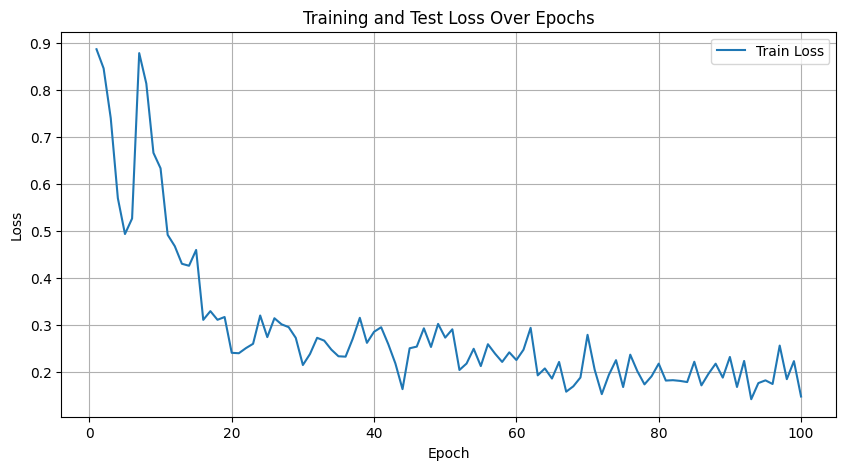

Training Concat Model...


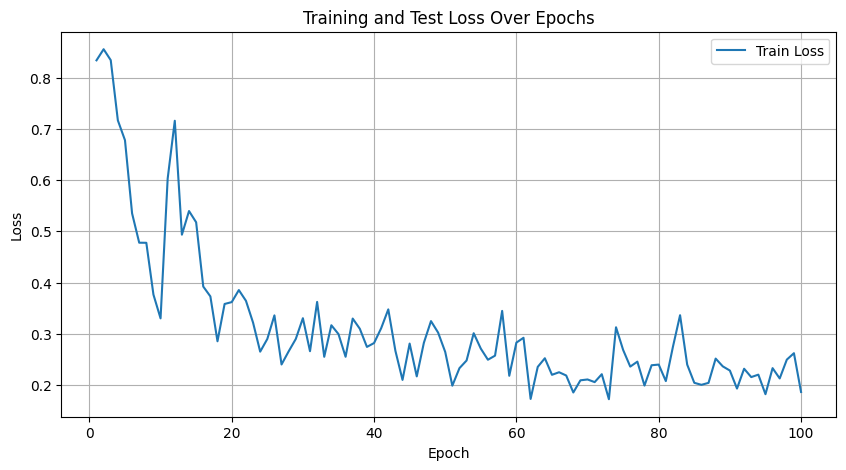

In [ ]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

# Define Optimizer
optimizer = optim.Adam(model_multiply.parameters(), lr=1e-5)

# DataLoader for all_crops_concat
train_loader_concat = get_dataloader(
    all_crops=all_crops_concat,
    mean=mean_concat,
    std=std_concat,
    num_augmentations=2,
    batchsize=32,
    include_original=False,
    crop=True,
    horizontalFlip=True,
    colorJitter=True,
    rotation=True,
    img_size=224
)

# DataLoader for all_crops_multiply
train_loader_multiply = get_dataloader(
    all_crops=all_crops_multiply,
    mean=mean_multiply,
    std=std_multiply,
    num_augmentations=2,
    batchsize=32,
    include_original=False,
    crop=True,
    horizontalFlip=True,
    colorJitter=True,
    rotation=True,
    img_size=224
)

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizers
triplet_loss = nn.TripletMarginLoss(margin=1.0)
optimizer_multiply = optim.Adam(model_multiply.parameters(), lr=1e-2)
optimizer_concat = optim.Adam(model_concat.parameters(), lr=1e-2)

# Train the multiply model
print("Training Multiply Model...")
train(
    loss_func=triplet_loss,
    model=model_multiply,
    optimizer=optimizer_multiply,
    train_loader=train_loader_multiply,
    epochs=100,
    device=device,
    plot_loss=True,
    test_loader=None  # Add test_loader if available
)

# Train the concat model
print("Training Concat Model...")
train(
    loss_func=triplet_loss,
    model=model_concat,
    optimizer=optimizer_concat,
    train_loader=train_loader_concat,
    epochs=100,
    device=device,
    plot_loss=True,
    test_loader=None  # Add test_loader if available
)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


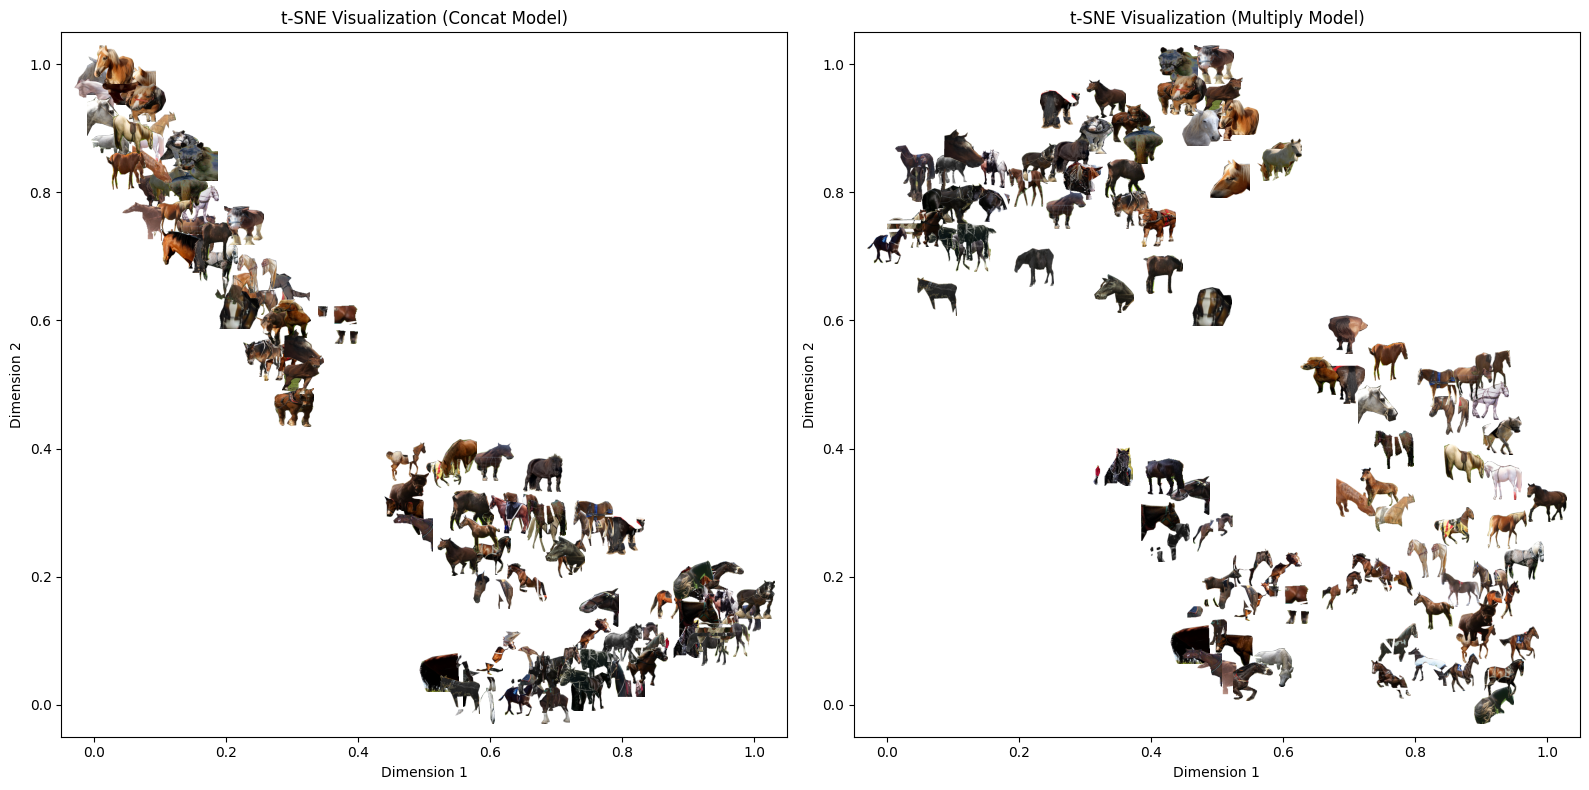

In [ ]:
def visualize_embeddings_with_images(model, dataloader, device, all_crops_alpha, num_samples=1000):

    model.eval()
    embeddings = []
    indices = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting embeddings"):
            augmented_views, batch_indices = batch  # batch_indices are the original indices
            batch_size, num_augmentations, C, H, W = augmented_views.size()


            views = augmented_views[:, 0, :, :, :].to(device)
            emb = model(views)
            embeddings.append(emb.cpu().numpy())
            indices.extend(batch_indices.cpu().numpy())

            # Limit the number of samples
            if len(indices) >= num_samples:
                break

    # Concatenate all embeddings and indices
    embeddings = np.vstack(embeddings)[:num_samples]
    indices = indices[:num_samples]

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Normalize t-SNE outputs for better image placement
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    embeddings_2d[:, 0] = (embeddings_2d[:, 0] - x_min) / (x_max - x_min)
    embeddings_2d[:, 1] = (embeddings_2d[:, 1] - y_min) / (y_max - y_min)

    return embeddings_2d, indices

def plot_tsne(ax, embeddings_2d, indices, all_crops_alpha, image_scale, title):
    for (x, y), idx in zip(embeddings_2d, indices):
        # Fetch the original image from all_crops_alpha
        img = all_crops_alpha[idx]

        # Convert to PIL image
        pil_img = F.to_pil_image(img)

        # Plot the image at the t-SNE location
        ax.imshow(pil_img, extent=(x - image_scale, x + image_scale, y - image_scale, y + image_scale), aspect='auto')

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

# Parameters
num_samples = 100
image_scale = 0.03

# Get t-SNE embeddings for both models
embeddings_2d_concat, indices_concat = visualize_embeddings_with_images(
    model=model_concat,
    dataloader=train_loader_concat,
    device=device,
    all_crops_alpha=all_crops_alpha,
    num_samples=num_samples
)

embeddings_2d_multiply, indices_multiply = visualize_embeddings_with_images(
    model=model_multiply,
    dataloader=train_loader_multiply,
    device=device,
    all_crops_alpha=all_crops_alpha,
    num_samples=num_samples
)

# Create a combined plot with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Concat Model
plot_tsne(
    ax=axes[0],
    embeddings_2d=embeddings_2d_concat,
    indices=indices_concat,
    all_crops_alpha=all_crops_alpha,
    image_scale=image_scale,
    title='t-SNE Visualization (Concat Model)'
)

# Plot for Multiply Model
plot_tsne(
    ax=axes[1],
    embeddings_2d=embeddings_2d_multiply,
    indices=indices_multiply,
    all_crops_alpha=all_crops_alpha,
    image_scale=image_scale,
    title='t-SNE Visualization (Multiply Model)'
)

plt.tight_layout()
plt.show()


### 2. Tracking


Implement a tracker using IoU-based association ("IoU-based Tracker"). Find a solution of how to deal with objects that appear or disappear within the sequence.
Plot the detections on the original video where the bounding box color indicates the instance.


Optional A: Implement a Kalman filter.  
Optional B: Apply your ReID model from exercise 1. You find the videos here: https://drive.google.com/drive/folders/1A7QbEa6encdOhjW8KRFg2YrK32Ot1-wv?usp=sharing

In [ ]:
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageFont

from torchvision.ops import box_iou, box_convert
from scipy.optimize import linear_sum_assignment

from utils import draw_bboxes


#Downloading the video data
!gdown --folder https://drive.google.com/drive/folders/1A7QbEa6encdOhjW8KRFg2YrK32Ot1-wv?usp=sharing
!unzip -o "/content/horse/horse.zip" -d  "/content/horse"

# Load detections
with open('horse_tracking_detections.json', 'r') as f:
    detections = json.load(f)

# Organize detections by frame
pred_by_frame = [
    [b[1:] for b in detections['horse_3_gt.txt'] if b[0] == i]
    for i in range(1, 100)
]


Retrieving folder contents
Processing file 1sHwlaSraYM_3K9WYjwGSQMiQLfLULx2- horse.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1sHwlaSraYM_3K9WYjwGSQMiQLfLULx2-
From (redirected): https://drive.google.com/uc?id=1sHwlaSraYM_3K9WYjwGSQMiQLfLULx2-&confirm=t&uuid=03d8f94f-bff9-4a63-9549-97abfb53a622
To: /content/horse/horse.zip
100% 160M/160M [00:01<00:00, 102MB/s]
Download completed
Archive:  /content/horse/horse.zip
   creating: /content/horse/videos/
  inflating: /content/horse/videos/horse_1.mp4  
  inflating: /content/horse/videos/horse_2.mp4  
  inflating: /content/horse/videos/horse_3.mp4  
  inflating: /content/horse/videos/horse_4.mp4  
  inflating: /content/horse/videos/horse_5.mp4  
  inflating: /content/horse/videos/horse_6.mp4  
  inflating: /content/horse/videos/horse_7.mp4  
   creating: /content/horse/gt/
  inflating: /content/horse/gt/horse_1_gt.t

In [ ]:
def match_two_frames(new_boxes, old_boxes_a, old_boxes_b=None, cutoff=0.0):

    if not old_boxes_a or not new_boxes:
        # If either frame has no detections, all matches are -1
        return np.full(len(new_boxes), -1, dtype=int)

    # Convert bounding boxes from 'cxcywh' to 'xyxy' format
    boxes1 = box_convert(torch.tensor(old_boxes_a), in_fmt='xywh', out_fmt='xyxy')
    boxes2 = box_convert(torch.tensor(new_boxes), in_fmt='xywh', out_fmt='xyxy')

    # Compute IoU matrix
    iou_matrix = box_iou(boxes1, boxes2)

    if old_boxes_b is not None:
        boxes1b = box_convert(torch.tensor(old_boxes_b), in_fmt='xywh', out_fmt='xyxy')
        iou_matrix_2 = box_iou(boxes1b, boxes2)
        iou_matrix = torch.max(iou_matrix, iou_matrix_2)

    # Perform Hungarian matching
    iou_matrix_np = iou_matrix.numpy()
    row_indices, col_indices = linear_sum_assignment(iou_matrix_np, maximize=True)

    # Assign matches where IoU exceeds the cutoff
    matches = np.full(len(new_boxes), -1, dtype=int)

    for r, c in zip(row_indices, col_indices):
        if iou_matrix_np[r, c] >= cutoff:
            matches[c] = r

    return matches


frame_1 = pred_by_frame[0]
frame_2 = pred_by_frame[1]

matches = match_two_frames(frame_1, frame_2, cutoff=0.8)

print(f"Total frames loaded: {len(pred_by_frame)}")
print(f"Detections in first frame: {pred_by_frame[0]}")
print(f"Detections in second frame: {pred_by_frame[1]}")
print(f"Matches from Frame 1 to Frame 2: {matches}")


Total frames loaded: 99
Detections in first frame: [[1276, 555, 909, 473], [0, 709, 152, 320], [321, 559, 655, 469], [99, 691, 287, 280]]
Detections in second frame: [[0, 713, 150, 320], [315, 557, 653, 469], [100, 691, 285, 276], [1284, 552, 898, 475]]
Matches from Frame 1 to Frame 2: [3 0 1 2]


In [ ]:
def simple_kalman_filter(last_P, last_x, z=None):

    #Not the best to hardcode this here but since we are only doing this simple case it's fine.
    R = np.eye(4) * 1
    Q = np.eye(8) * 100

    H= np.hstack([np.eye(4), np.zeros((4, 4))])
    F = np.array([
    [1, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1]
    ], dtype=float)

    #Here we do the prediction after the update since we want to use the prediction for hungarian matching:
    #Update
    if z is not None:
        K = last_P @ H.T @ np.linalg.inv(H @ last_P @ H.T + R)
        x = last_x + K @ (z - H @ last_x)
        P = (np.eye(8) - K @ H) @ last_P

    #Predict
    x_next = F @ last_x
    P_next = F @ P @ F.T + Q

    return x, x_next, P_next


In [ ]:
def simple_IOU_tracker(pred_by_frame, cutoff=0.0):

    pred_matched = []
    initial_P = np.diag([10.0, 10.0, 50.0, 50.0, 100.0, 100.0, 200.0, 200.0])

    #Initialize the tracking for frame 0
    x_prev = []
    P_prev = []
    x_pred = []

    for i in range(len(pred_by_frame[0])):
        x = pred_by_frame[0][i] + [0, 0, 0, 0]
        P = initial_P.copy()
        x_prev.append(x)
        P_prev.append(P)
        x_pred.append(x)

    #------------- MAIN LOOP --------------#
    for i in range(len(pred_by_frame) - 1):
        #Match the predicted positions and the detections using IoU loss and Hungarian Matching
        pred_pos = [x[:4] for x in x_pred]
        prev_pos = [x[:4] for x in x_prev]
        measured_pos = pred_by_frame[i + 1]

        #Match results using the calman filter positions
        match_result = match_two_frames(measured_pos, pred_pos, prev_pos, cutoff=cutoff)
        found_indecies = []

        #Loop over all predictions and apply kalman filter
        for j, k in enumerate(match_result):
            if k != 1:
                #Updating a detection

                x, x_next, P_next = simple_kalman_filter(P_prev[k], x_prev[k], measured_pos[j])

                found_indecies.append(k)

                # Store updated results in track k (NOT j):
                x_prev[k] = x
                P_prev[k] = P_next
                x_pred[k] = x_next

            else:
                #Initalize new Detection

                found_indecies.append(len(x_prev))

                new_x = measured_pos[j] + [0, 0, 0, 0]
                x_prev.append(new_x)
                P_prev.append(initial_P.copy())
                x_pred.append(new_x)


        temp = []
        for j, x in enumerate(x_prev):
            if j in found_indecies:
                temp.append(x[:4])
            else:
                temp.append(np.zeros(4))

        pred_matched.append(temp)

    return pred_matched

In [ ]:
def load_detections(detections_dict, file_key, max_frames=1000):
    return [
        [b[1:] for b in detections_dict[file_key] if b[0] == i]
        for i in range(1, max_frames+1)
    ]


def create_combined_video_with_text(
    video_path,
    original_bboxes,
    tracked_bboxes,
    output_path,
    size=(1440, 2560),
    resize_factor=0.5,
    black_frames=2
):

    # -------------------- Open the input video --------------------
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0:
        fps = 30  # fallback

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # The final frames after draw_bboxes => (height*resize_factor, width*resize_factor)
    out_w = int(width  * resize_factor)
    out_h = int(height * resize_factor)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (out_w, out_h))

    font = ImageFont.load_default()

    # ================= PASS 1: "ORIGINAL DETECTIONS" =================
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # rewind
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret or frame_idx >= len(original_bboxes):
            break

        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resize to match 'size=(1440,2560)' if your video isn't already that resolution
        if (height, width) != size:
            frame_rgb = cv2.resize(frame_rgb, (size[1], size[0]))

        frame_tensor = torch.from_numpy(frame_rgb).permute(2, 0, 1).float()

        # bounding boxes for this frame
        bboxes_this_frame = np.array(original_bboxes[frame_idx]) if frame_idx < len(original_bboxes) else []

        # Draw bounding boxes
        drawn_img_pil = draw_bboxes(
            bboxes=bboxes_this_frame,
            labels=np.arange(len(bboxes_this_frame)),
            img=frame_tensor,
            bboxes_format='xywh',
            size=size,
            resize_factor=resize_factor
        )

        # ----------------- Overlay text: "ORIGINAL DETECTIONS" -----------------
        draw = ImageDraw.Draw(drawn_img_pil)
        text_str = "ORIGINAL DETECTIONS"
        draw.text((50, 50), text_str, font=font, fill=(127, 0, 0))

        # Convert PIL -> np -> BGR
        drawn_img_np = np.array(drawn_img_pil)
        drawn_img_bgr = cv2.cvtColor(drawn_img_np, cv2.COLOR_RGB2BGR)
        out.write(drawn_img_bgr)

        frame_idx += 1

    # ================= Insert black frames =================
    blank = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    for _ in range(black_frames):
        out.write(blank)

    # ================= PASS 2: "TRACKED DETECTIONS" =================
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # rewind again
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret or frame_idx >= len(tracked_bboxes):
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if (height, width) != size:
            frame_rgb = cv2.resize(frame_rgb, (size[1], size[0]))

        frame_tensor = torch.from_numpy(frame_rgb).permute(2,0,1).float()

        bboxes_this_frame = np.array(tracked_bboxes[frame_idx]) if frame_idx < len(tracked_bboxes) else []

        drawn_img_pil = draw_bboxes(
            bboxes=bboxes_this_frame,
            labels=np.arange(len(bboxes_this_frame)),
            img=frame_tensor,
            bboxes_format='xywh',
            size=size,
            resize_factor=resize_factor
        )

        # ----------------- Overlay text: "TRACKED DETECTIONS" -----------------
        draw = ImageDraw.Draw(drawn_img_pil)
        text_str = "TRACKED DETECTIONS"
        draw.text((10, 10), text_str, font=font, fill=(255, 255, 255))

        drawn_img_np = np.array(drawn_img_pil)
        drawn_img_bgr = cv2.cvtColor(drawn_img_np, cv2.COLOR_RGB2BGR)
        out.write(drawn_img_bgr)

        frame_idx += 1

    cap.release()
    out.release()
    print(f"Combined video saved to: {output_path}")


In [ ]:
video_ids = range(1, 8)
base_video_dir = "/content/horse/videos"
base_output_dir = "/content/horse/videos/output"

for i in video_ids:
    file_key = f"horse_{i}_gt.txt"
    video_path = os.path.join(base_video_dir, f"horse_{i}.mp4")
    output_path = os.path.join(base_output_dir, f"horse_{i}_combined.mp4")

    # Load original detections
    original_pred_by_frame = load_detections(detections, file_key)

    # Suppose you run your tracker
    tracked_pred_by_frame = simple_IOU_tracker(original_pred_by_frame, cutoff=0.0)

    # Now create the combined video with text overlays
    create_combined_video_with_text(
        video_path=video_path,
        original_bboxes=original_pred_by_frame,
        tracked_bboxes=tracked_pred_by_frame,
        output_path=output_path,
        size=(1440,2560),
        resize_factor=1,
        black_frames=2
    )


Combined video saved to: /content/horse/videos/output/horse_1_combined.mp4
Combined video saved to: /content/horse/videos/output/horse_2_combined.mp4
Combined video saved to: /content/horse/videos/output/horse_3_combined.mp4
Combined video saved to: /content/horse/videos/output/horse_4_combined.mp4
Combined video saved to: /content/horse/videos/output/horse_5_combined.mp4
Combined video saved to: /content/horse/videos/output/horse_6_combined.mp4
Combined video saved to: /content/horse/videos/output/horse_7_combined.mp4


In [ ]:
#Make output videos avaiable on Drive:

import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

dst_folder = "/content/drive/MyDrive/HorseTracking"
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)
    print(f"Created folder: {dst_folder}")
else:
    print(f"Folder already exists: {dst_folder}")

src_folder = "/content/horse/videos/output"
!cp -r "$src_folder" "$dst_folder"

print(f"\nContents of '{dst_folder}':")
!ls -R "$dst_folder"


Mounted at /content/drive
Folder already exists: /content/drive/MyDrive/HorseTracking

Contents of '/content/drive/MyDrive/HorseTracking':
/content/drive/MyDrive/HorseTracking:
output

/content/drive/MyDrive/HorseTracking/output:
horse_1_combined.mp4  horse_3_combined.mp4  horse_5_combined.mp4  horse_7_combined.mp4
horse_2_combined.mp4  horse_4_combined.mp4  horse_6_combined.mp4


Videos available under: https://drive.google.com/drive/folders/1Sz6WO-_dzMOKgRazQX-4CJNZSD9nuWW2?usp=sharing